# Workshop Python Image Analysis
*Martijn Wehrens, September 2025*



## Answers to exercises 03

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile as tiff
import numpy as np

import skimage as sk
from scipy import stats
from scipy import ndimage

def my_plot_1(img1, mycmap='gray', myfigsize=(5/2.54,5/2.54)):
    fig, ax = plt.subplots(1,1, figsize=myfigsize)
    _=plt.imshow(img1, cmap=mycmap) 
    
def my_plot_12(img1, img2, mycmap='viridis', myfigsize=(10/2.54,5/2.54)):
    # plot two images side by side
    fig, axs = plt.subplots(1,2, figsize=myfigsize)
    _ = axs[0].imshow(img1, cmap=mycmap)
    _ = axs[1].imshow(img2, cmap=mycmap)  
    plt.tight_layout()     

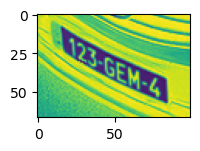

In [24]:
img_shady = tiff.imread('../images/car/chatGPT_shadybusiness_licensehigh-8bit.tif')
img_shady_inv = np.max(img_shady)-img_shady
my_plot_1(img_shady_inv, mycmap='viridis')

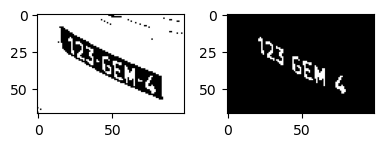

In [35]:
# Segment the symbols on the license plate

# apply triangle thresholding
thresh = sk.filters.threshold_otsu(img_shady_inv)
# get the mask
mask_shady = img_shady_inv>thresh
mask_shady_labeled = sk.measure.label(mask_shady)
props_shady = sk.measure.regionprops(mask_shady_labeled)
# retain labels that are >10, <100 in area
mask_shady_filt = np.isin(mask_shady_labeled, 
                          [p.label for p in props_shady if p.area>5 and p.area<200])

# show result
my_plot_12(mask_shady, mask_shady_filt, mycmap='gray')

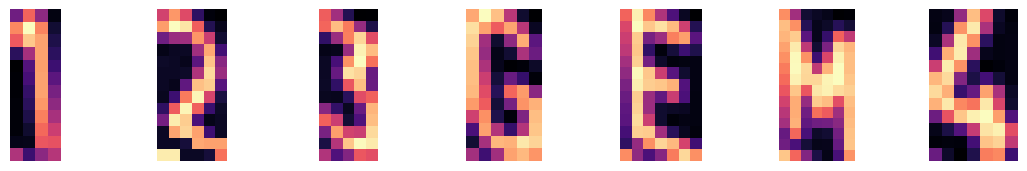

In [34]:
# acquire labels and regionprops
mask_shady_filt_label = sk.measure.label(mask_shady_filt)
props_shady = sk.measure.regionprops(mask_shady_filt_label)

# plot every bbox separately
fig, axs = plt.subplots(1,len(props_shady), figsize=(len(props_shady)*5/2.54,5/2.54))
for i, p in enumerate(props_shady):
    minr, minc, maxr, maxc = p.bbox
    # Plot (and remove axes)
    _ = axs[i].imshow(img_shady_inv[minr:maxr, minc:maxc], cmap='magma')
    axs[i].axis('off')

## Distance transform

In [41]:
# load images
img_path_KTR = '/Users/m.wehrens/Data_notbacked/2025_Py-Image-workshop_KTR-example-data/raw/Composite_KTR.tif'
img_nuclei = tiff.imread(img_path_KTR)[0, 0, 0:200, 0:200]

# Let's also load an image of some bacteria (Wehrens et al.)
path_img_ecoli = '../images/biological/microcolony_ecoli.tif'
img_ecoli = tiff.imread(path_img_ecoli)
img_ecoli_inv = np.max(img_ecoli)-img_ecoli # invert image

# create mask
mask_nuclei_triangle = img_nuclei > sk.filters.threshold_triangle(img_nuclei)
mask_ecoli_triangle = img_ecoli_inv > sk.filters.threshold_triangle(img_ecoli_inv)

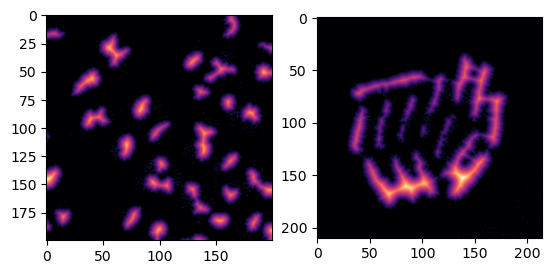

In [42]:
# Perform a distance perform on the bacterial image
distance_nuclei = ndimage.distance_transform_edt(mask_nuclei_triangle)
distance_ecoli  = ndimage.distance_transform_edt(mask_ecoli_triangle)


# Show it
fig, axs = plt.subplots(1,2)
_=axs[0].imshow(distance_nuclei, cmap='magma')
_=axs[1].imshow(distance_ecoli, cmap='magma')

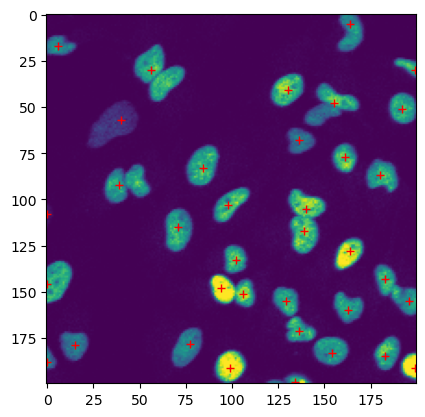

In [43]:
# Get local maxima for the nuclei
local_max_nuclei = sk.feature.peak_local_max(distance_nuclei, 
                                             min_distance = 10,
                                             threshold_abs = 3,
                                             footprint=sk.morphology.disk(10),
                                             exclude_border=False)

# Plot the nuclei picture, and plot the local maxima on top as crosses
fig, ax = plt.subplots()
_ = ax.imshow(img_nuclei, cmap='viridis')
x = local_max_nuclei[:, 1]
y = local_max_nuclei[:, 0]
_ = ax.plot(x, y, 'r+')
